In [35]:
import operator

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

pdf_loader = PyPDFLoader("E:/agenticai/data/attention_is_all_you_need.pdf")
documents = pdf_loader.load()
pdf_text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
split_docs = pdf_text_splitter.split_documents(documents)
split_docs


[Document(metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2024-04-10T21:11:43+00:00', 'author': '', 'keywords': '', 'moddate': '2024-04-10T21:11:43+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': 'E:/agenticai/data/attention_is_all_you_need.pdf', 'total_pages': 15, 'page': 0, 'page_label': '1'}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁuk

In [36]:
relevant_docs = []
for i in range(len(split_docs)):
    if split_docs[i].metadata['page'] <= 1 or split_docs[i].metadata['page'] > len(split_docs) - 5:
        continue
    relevant_docs.append(split_docs[i])
len(relevant_docs)

42

In [37]:
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings

embedding_db = OllamaEmbeddings(model="nomic-embed-text:latest")
fdb = FAISS.from_documents(documents=relevant_docs, embedding=embedding_db)

In [38]:
from langchain_ollama import ChatOllama

base_llm_model = ChatOllama(model="gemma:2b")

In [39]:
from langchain_core.documents import Document
from langgraph.graph import add_messages
from typing_extensions import TypedDict, Annotated, List


class TopicInformation(TypedDict):
    title: str
    content: str


class AgentClass(TypedDict):
    messages: Annotated[List[str], add_messages]
    documents: List[Document]
    topics: Annotated[List[str], operator.add]
    summary: Annotated[List[TopicInformation], operator.add]
    web_results: Annotated[List[TopicInformation], operator.add]


In [40]:
from langchain_core.messages import BaseMessage


def get_last_message(state: AgentClass) -> BaseMessage:
    return state['messages'][-1]

In [41]:
def init(state: AgentClass):
    pass

In [42]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import Field
from groq import BaseModel
from typing_extensions import TypedDict, List, Literal

def router(state: AgentClass) -> Literal["generate_topics", "get_user_topics"]:
    """ Checks if user has given any specific topic """
    user_query = get_last_message(state).content
    if user_query== "":
            return "generate_topics"
    return "get_user_topics"

In [43]:
import random
from langgraph.types import Send


class TopicGeneratorWorkerState(TypedDict):
    document: Document


class DocumentRelevantTopicStructuredState(BaseModel):
    topic: str = Field(description="Summarized topic name from given input")


llm_with_structured_output_for_topic_generation = base_llm_model.with_structured_output(
    DocumentRelevantTopicStructuredState)

template = ChatPromptTemplate.from_template("""
    You are an AI assistant. Analyse at the content given below and generate a relevant topic name that summarizes given content.
    Content: {context}
""")


def topic_generator_worker(topic_generator_worker_state: TopicGeneratorWorkerState):
    chain = template | llm_with_structured_output_for_topic_generation
    print("=============topic_generator_worker=============")
    print(topic_generator_worker_state['document'].page_content)
    result = chain.invoke({"context": topic_generator_worker_state['document'].page_content})
    return {"topics": [result.topic]}


def topic_generator_orchestrator(state: AgentClass):
    return [Send("topic_generator_worker", {"document": document}) for document in state['documents']]


def generate_topics(state: AgentClass):
    lb = 0
    ub = len(relevant_docs)
    random_docs_idxs = [random.randint(lb, ub) for _ in range(3)]
    return {"documents": [relevant_docs[random_docs_idxs] for random_docs_idxs in random_docs_idxs]}



In [44]:
# llm_with_structured_output_for_topic_generation


template = ChatPromptTemplate.from_template("""
    You are an AI assistant. You are to look at the query given below and determine if the user has
    either
        Asked for explanation on any topics
    or
        Given any topics

    and
        Respond with a list of properly formatted topics

    Eg. Query: Please explain me what is calculus and limits?
        Response: ['Calculus','Limits']

    Eg. Query: Calculus
        Response: ['Calculus']

    Query: {context}
""")


class DocumentRelevantTopicStructuredState(BaseModel):
    topics: List[str] = Field(description="List of topics generated from the users query")


llm_with_structured_output_for_multiple_topic_generation = base_llm_model.with_structured_output(
    DocumentRelevantTopicStructuredState)


def get_user_topics(state: AgentClass):
    chain = template | llm_with_structured_output_for_multiple_topic_generation
    last_message = get_last_message(state).content
    result = chain.invoke(last_message)
    topics = random.sample(result.topics, k=min(len(result.topics), 3))
    return {"topics": topics}


In [45]:
from duckduckgo_search.exceptions import DuckDuckGoSearchException
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.tools import DuckDuckGoSearchRun


def parse_and_format_topics(state: AgentClass):
    pass


def worker(state: AgentClass):
    pass


def worker_orchestrator(state: AgentClass):
    topic_summarizer_task = [Send("topic_summarizer", {"topic": topic}) for topic in state['topics']]
    web_info_getter_task = [Send("web_info_getter", {"topic": topic}) for topic in state['topics']]
    return topic_summarizer_task + web_info_getter_task


template = ChatPromptTemplate.from_template("""
    You are an AI assistant. Your job is to summarize the below topic.
    Topic: {context}
""")

document_chain = create_stuff_documents_chain(base_llm_model, template)
retrieval_chain = create_retrieval_chain(fdb.as_retriever(), document_chain)


class WorkerState(TypedDict):
    topic: str


def topic_summarizer(state: WorkerState):
    topic_title = state['topic']
    result = retrieval_chain.invoke({"input": topic_title})
    return {"summary": [{"title": topic_title, "content": result['answer']}]}


def web_info_getter(state: WorkerState):
    search_tool = DuckDuckGoSearchRun()
    topic_title = state['topic']
    result = ""
    try:
        result += search_tool.invoke(topic_title)
    except DuckDuckGoSearchException:
        result += "ERROR_RATE_LIMIT_REACHED"
    return {"web_results": [{"title": topic_title, "content": result}]}

In [46]:
def aggregator(state: AgentClass):
    pass

In [47]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
config = {"configurable": {"thread_id": "abc"}}

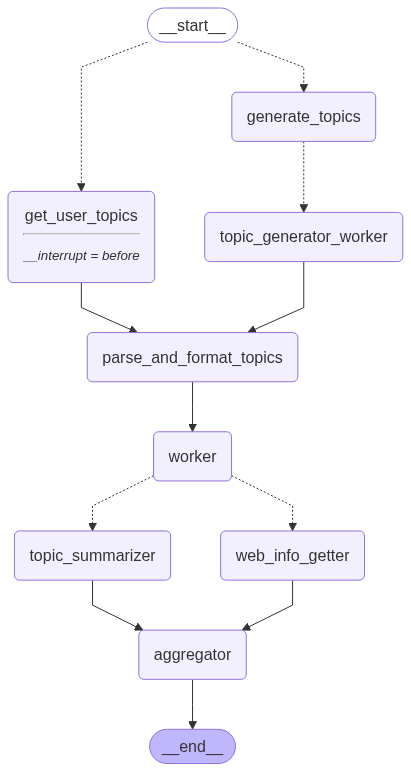

In [48]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(AgentClass)

graph_builder.add_node("generate_topics", generate_topics)
graph_builder.add_node("topic_summarizer", topic_summarizer)
graph_builder.add_node("web_info_getter", web_info_getter)
graph_builder.add_node("worker", worker)
graph_builder.add_node("aggregator", aggregator)
graph_builder.add_node("get_user_topics", get_user_topics)
graph_builder.add_node("parse_and_format_topics", parse_and_format_topics)
graph_builder.add_node("topic_generator_worker", topic_generator_worker)
# graph_builder.add_node("orchestrator", topic_generator_worker)

graph_builder.add_conditional_edges(START, router,
                                    {"generate_topics": "generate_topics", "get_user_topics": "get_user_topics"})

graph_builder.add_edge("get_user_topics", "parse_and_format_topics")
graph_builder.add_conditional_edges("generate_topics", topic_generator_orchestrator, ["topic_generator_worker"])
graph_builder.add_edge("topic_generator_worker", "parse_and_format_topics")

graph_builder.add_edge("parse_and_format_topics", "worker")
graph_builder.add_conditional_edges("worker", worker_orchestrator, ["topic_summarizer", "web_info_getter"])
graph_builder.add_edge("topic_summarizer", "aggregator")
graph_builder.add_edge("web_info_getter", "aggregator")
graph_builder.add_edge("aggregator", END)

graph = graph_builder.compile(checkpointer=memory, interrupt_before=["get_user_topics"])
graph

In [49]:
# result = graph.invoke({"messages": "yash"})
# result

for i in graph.stream({"messages":""}, config=config, stream_mode="values"):
    pass

=============topic_generator_worker=============
P Epos.
We also experimented with using learned positional embeddings [9] instead, and found that the two
versions produced nearly identical results (see Table 3 row (E)). We chose the sinusoidal version
because it may allow the model to extrapolate to sequence lengths longer than the ones encountered
during training.
4 Why Self-Attention
In this section we compare various aspects of self-attention layers to the recurrent and convolu-
tional layers commonly used for mapping one variable-length sequence of symbol representations
(x1, ..., xn) to another sequence of equal length (z1, ..., zn), with xi, zi ∈ Rd, such as a hidden
layer in a typical sequence transduction encoder or decoder. Motivating our use of self-attention we
consider three desiderata.
One is the total computational complexity per layer. Another is the amount of computation that can
be parallelized, as measured by the minimum number of sequential operations required.
====

In [50]:
# from langchain_core.messages import HumanMessage
#
# graph.update_state(config, {"messages": [HumanMessage("Explain decoders")]})
# for i in graph.stream(None, config=config, stream_mode="values"):
#     pass


In [51]:
graph.get_state(config).values

{'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='9f0a54a2-19db-49ea-b270-e8d5dbcb5d46')],
 'documents': [Document(metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2024-04-10T21:11:43+00:00', 'author': '', 'keywords': '', 'moddate': '2024-04-10T21:11:43+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': 'E:/agenticai/data/attention_is_all_you_need.pdf', 'total_pages': 15, 'page': 5, 'page_label': '6'}, page_content='P Epos.\nWe also experimented with using learned positional embeddings [9] instead, and found that the two\nversions produced nearly identical results (see Table 3 row (E)). We chose the sinusoidal version\nbecause it may allow the model to extrapolate to sequence lengths longer than the ones encountered\nduring training.\n4 Why Self-Attention\nIn this section we compare va